In [214]:
# Importing modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [326]:
# Reading in the data
tesla = pd.read_csv('TSLA.csv')

In [327]:
tesla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [328]:
# Isolating the date and close price
tesla = tesla[['Date', 'Close']]

In [329]:
tesla.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [330]:
# Converting the date series to a datetime object
tesla.Date = pd.to_datetime(tesla.Date, format = '%Y/%m/%d')

In [331]:
# Setting the index 
plot_tesla = tesla.set_index('Date')

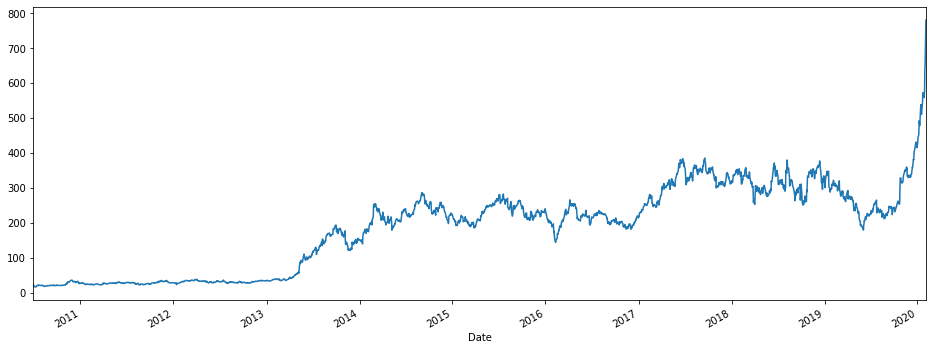

In [332]:
plot_tesla['Close'].plot(figsize=(16,6))

# Selecting the portion of dataset we want to predict
Upon visual inspection, the time series is roughly stationary from the period of 2014 through 2017, so let's reduce the dataset to 2014 through 2017. We then can predict the first few weeks of 2018 with a high degree of accuracy.

Start date: 1/1/14 -> index = 884

End date: 12/31/17 -> index = 1890

In [333]:
new_tesla = tesla.loc[884:1890]

In [334]:
new_tesla.head()

,Date,Close
884,2014-01-02,150.100006
885,2014-01-03,149.559998
886,2014-01-06,147.000000
887,2014-01-07,149.360001
888,2014-01-08,151.279999


In [335]:
new_tesla.tail()

,Date,Close
1886,2017-12-22,325.200012
1887,2017-12-26,317.290009
1888,2017-12-27,311.640015
1889,2017-12-28,315.359985
1890,2017-12-29,311.350006


In [336]:
new_tesla = new_tesla.drop('Date', axis = 1)
new_tesla = new_tesla.reset_index(drop = True)
new_tesla.head()
T = new_tesla.values
T = T.astype('float32')
T = np.reshape(T, (-1, 1))

In [337]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
T = scaler.fit_transform(T)

# 80-20 split
train_size = int(len(T) * 0.80)
test_size = int(len(T) - train_size)
train, test = T[0:train_size,:], T[train_size:len(T),:]

In [338]:
# Method for converting a time series dataset to a supervised learning problem
def convert_to_supervised(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

# Roughly one month of trading assuming 5 trading days per month
window_size = 20
X_train, Y_train = convert_to_supervised(train, window_size)

X_test, Y_test = convert_to_supervised(test, window_size)

# Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [297]:
# Model imports
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks.callbacks import ModelCheckpoint

In [298]:
# Setting seed for reproducibility 
tf.random.set_seed(11)
np.random.seed(11)

In [301]:
# Building model
model = Sequential()

model.add(LSTM(units = 25, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], window_size)))
model.add(Dropout(0.2))

model.add(LSTM(units = 25, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [302]:
filepath = 'model_epoch_{epoch:02d}.hdf5'

checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode ='min'
                            )

history = model.fit(X_train, Y_train, epochs = 50, batch_size = 20, validation_data = (X_test, Y_test), 
                    callbacks = [checkpoint], 
                    verbose = 1, shuffle = False)

model.summary()

Train on 784 samples, validate on 181 samples
Epoch 1/50
784/784 [==============================] - 4s 5ms/step - loss: 0.1050 - val_loss: 0.4166

Epoch 00001: val_loss improved from inf to 0.41664, saving model to model_epoch_01.hdf5
Epoch 2/50
784/784 [==============================] - 0s 342us/step - loss: 0.0422 - val_loss: 0.0127

Epoch 00002: val_loss improved from 0.41664 to 0.01266, saving model to model_epoch_02.hdf5
Epoch 3/50
784/784 [==============================] - 0s 349us/step - loss: 0.0115 - val_loss: 0.0111

Epoch 00003: val_loss improved from 0.01266 to 0.01110, saving model to model_epoch_03.hdf5
Epoch 4/50
784/784 [==============================] - 0s 339us/step - loss: 0.0094 - val_loss: 0.0101

Epoch 00004: val_loss improved from 0.01110 to 0.01012, saving model to model_epoch_04.hdf5
Epoch 5/50
784/784 [==============================] - 0s 333us/step - loss: 0.0090 - val_loss: 0.0091

Epoch 00005: val_loss improved from 0.01012 to 0.00905, saving model to model

In [339]:
from keras.models import load_model

best_model = load_model('model_epoch_05.hdf5')

train_predict = best_model.predict(X_train)

Y_hat_train = scaler.inverse_transform(train_predict)

test_predict = best_model.predict(X_test)

Y_hat_test = scaler.inverse_transform(test_predict)

Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

In [343]:
Y_hat_train = np.reshape(Y_hat_train, newshape = 784)
Y_hat_test = np.reshape(Y_hat_test, newshape = 181)

Y_train = np.reshape(Y_train, newshape = 784)
Y_test = np.reshape(Y_test, newshape = 181)

[186.7281  187.42145 187.49605 188.7271  188.76727 189.63872 189.69356
 191.13611 192.10538 193.36441 194.16806 194.33035 195.28719 195.2815
 196.38225 197.14253 198.28325 200.31003 201.42775 204.17169 205.6176
 208.15898 210.28323 212.2462  214.90141 217.47635 221.3551  221.62328
 223.49797 224.17682 225.0487  226.68822 228.42393 230.18361 229.57571
 230.5226  230.87758 230.3018  228.10031 226.48764 225.58562 223.47621
 222.643   221.81424 220.22603 219.03448 218.67972 217.71516 216.48589
 215.36246 214.60641 214.20874 213.30525 211.49316 209.75261 209.1674
 209.00464 208.68266 209.16733 208.68353 207.52872 207.78107 207.54857
 206.85663 206.78113 207.34996 206.98712 206.60632 205.44275 204.69302
 204.7587  203.84859 204.17319 203.56836 204.11629 203.24821 202.55719
 201.61064 201.47197 202.19539 202.59221 203.11491 202.59071 202.98172
 202.54091 202.75829 202.43028 202.7923  203.43073 204.3501  204.8361
 205.07701 205.33385 205.6923  206.55739 207.24687 208.52762 209.61395
 210.25638

In [348]:
from sklearn.metrics import mean_squared_error

train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_hat_train))

test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_hat_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
16.672144749625726 

Test RMSE is: 
23.374413920975353


In [353]:
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_hat_train, Y_hat_test)

In [368]:
result_df = pd.DataFrame()

result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat


result_df.head()

,Actual_Y,Predicted_Y
0,181.410004,186.728104
1,177.110006,187.421448
2,178.729991,187.496048
3,174.419992,188.727097
4,178.380007,188.767273


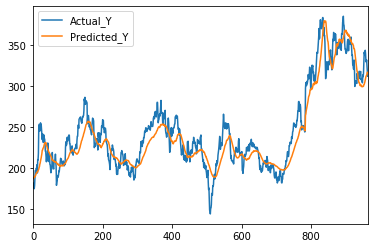

In [369]:
result_df.plot()